In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


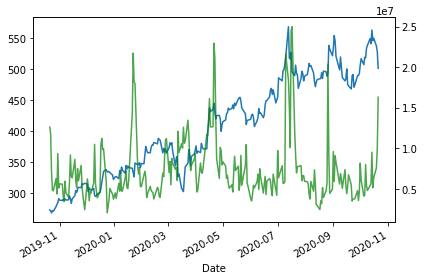

In [63]:
#df=pd.read_csv('GOOG.csv')
df=pd.read_csv('nflx.csv')
#df=pd.read_csv('nio.csv')
#df=pd.read_csv('dpz.csv')
#df=pd.read_csv('dis.csv')
#df=pd.read_csv('aapl.csv')
#df=pd.read_csv('VMW.csv')
#df=pd.read_csv('MSFT.csv')

df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')
df=df.sort_values(by='Date',ascending=True)
print(df.columns)
fig,ax=plt.subplots(figsize=(6,4))
df['Open'].plot(ax=ax)
twin_ax=ax.twinx()

df['Volume'].plot(ax=twin_ax, c='green', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [64]:
#df=df.asfreq('B').fillna(0)
#for key, item in df.iterrows():
#    print(key,item)

In [65]:
df['Shifted 1D']=df.Open.shift()
df['Shifted 2D']=df.Open.shift(periods=2)
df['Open_PCT']=df['Open'].pct_change()

df["Buy_Count"]=0

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["Open_PCT"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('Buy_Count')]=count
    
df['Action']=[ 'Sell' if x['Buy_Count']==0 else 'Buy' if x['Buy_Count']==2 else 'Hold' if x['Buy_Count'] > 2 else 'No Action' for key,x in df.iterrows()]

df["Target"]=0
for index in range(len(df)):
    action=df.iloc[index]["Action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('Target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('Target')]=2

print(df[['Target','Action','Open_PCT','Open','Shifted 1D','Shifted 2D','Buy_Count']])



            Target     Action  Open_PCT        Open  Shifted 1D  Shifted 2D  \
Date                                                                          
2019-10-21       2       Sell       NaN  272.890015         NaN         NaN   
2019-10-22       2       Sell -0.006340  271.160004  272.890015         NaN   
2019-10-23       2       Sell -0.011432  268.059998  271.160004  272.890015   
2019-10-24       0  No Action  0.013989  271.809998  268.059998  271.160004   
2019-10-25       2       Sell -0.004157  270.679993  271.809998  268.059998   
...            ...        ...       ...         ...         ...         ...   
2020-10-15       2       Sell -0.030376  545.520020  562.609985  540.559998   
2020-10-16       0  No Action  0.007296  549.500000  545.520020  562.609985   
2020-10-19       2       Sell -0.022621  537.070007  549.500000  545.520020   
2020-10-20       2       Sell -0.016627  528.140015  537.070007  549.500000   
2020-10-21       2       Sell -0.051331  501.029999 

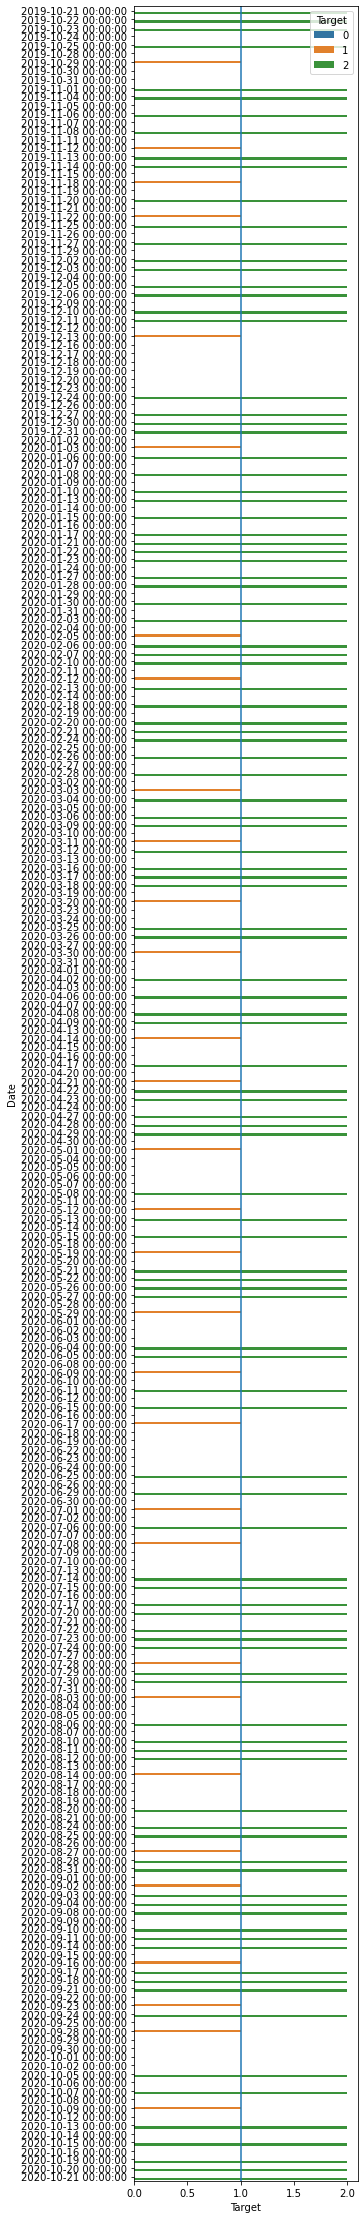

In [66]:
colors=[]
[colors.append('Red') if x=='2' else colors.append('Green') if x==1 else colors.append('White') for x in df['Target']]
plt.figure(figsize=(4, 40))
#names.arg = colors
sns.barplot(data=df, x='Target', y=df.index, hue='Target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.show()

   Buy_Count  Incidence  Size
0          0          2   114
1          1          0    66
2          2          1    31
3          3          0    17
4          4          0    12
5          5          0     7
6          6          0     4
7          7          0     2
8          8          0     1
Number of Buys in the Data 17
Number of days holding Open          43
High          43
Low           43
Close         43
Adj Close     43
Volume        43
Shifted 1D    43
Shifted 2D    43
Open_PCT      43
Buy_Count     43
Action        43
Target        43
dtype: int64
Incidence shows the average target value for each group


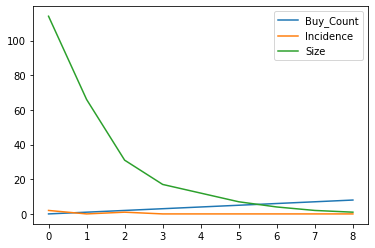

In [67]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

pig_table = create_pig_table(df, "Target", "Buy_Count")
print(pig_table)

print("Number of Buys in the Data", len(df[df['Buy_Count']==3]))

print("Number of days holding", df[(df["Action"]=='Hold')].count())

print("Incidence shows the average target value for each group")

pig_table.plot()
plt.show()

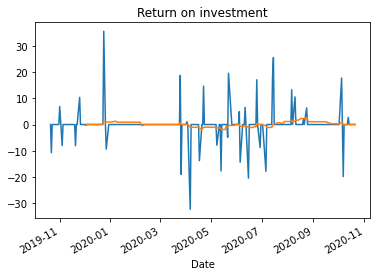

In [68]:
#df['Return']=df[df['Open']]
sellAmt=0
sellIndex=0
buyAmt=0
df['Return']=0
previousAction=""
for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        row=df.iloc[index2]
        #Print(row.Action, row.Open, row.Return)
        if row.Action=='Sell':
            if previousAction=='Sell':
                break
            sellAmt=row.Open
            sellIndex=index2
        if row.Action=='Buy' and (previousAction=='Hold' or previousAction=='Sell'):
            #print("Buy", sellIndex,index2)
            buyAmt=row.Open
            #print("Return",  previousAction, buyAmt,sellAmt,index2,sellIndex)
            df.iloc[sellIndex, df.columns.get_loc('Return')]=sellAmt-buyAmt
            break
        if row.Action=='No Action':
            break
        previousAction=row.Action
            
    #df.iloc[index, df.columns.get_loc('Buy_Count')]=count

#for key,item in df.iterrows():
#    print(item.Action,item.Open, "Return", item.Return)


df['Return_Avg'] = df['Return'].rolling(
    window=30,
    center=False
).mean()

df['Return'].plot()
df['Return_Avg'].plot()
plt.title('Return on investment')
plt.show()